In [317]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import time

In [251]:
def gen_dataset(f, noise, N, dom=[10, 90]):
    X = np.linspace(dom[0], dom[1], N)
    Y = f(np.copy(X))
    X += np.random.uniform(-noise, noise, N)
    Y += np.random.uniform(-noise, noise, N)
    return np.vstack([X, Y])

def summary_statistics(data):
    X, Y = data[0, :], data[1, :]
    return np.array([
        np.mean(X),
        np.mean(Y),
        np.std(X),
        np.std(Y),
        np.corrcoef(X, Y)[0, 1]
    ])

def plot_data(data):
    X, Y = data[0, :], data[1, :]
    plt.scatter(X, Y)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect("equal")

def plot_summary(data):
    x_mean, y_mean, x_std, y_std, r = summary_statistics(data)
    plt.text(105, 90,
            f"X Mean: {x_mean:.2f}\nY Mean: {y_mean:.2f}\nX Std: {x_std:.2f}\nY Std: {y_std:.2f}\nR: {r:.2f}",
            verticalalignment="top")

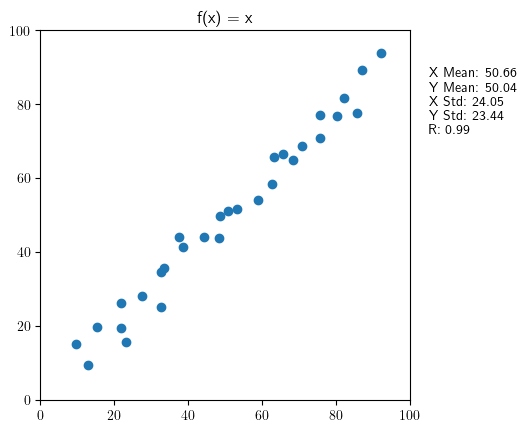

In [252]:
data = gen_dataset(lambda x: x, 5, 30)
plt.title("f(x) = x")
plot_summary(data)
plot_data(data)

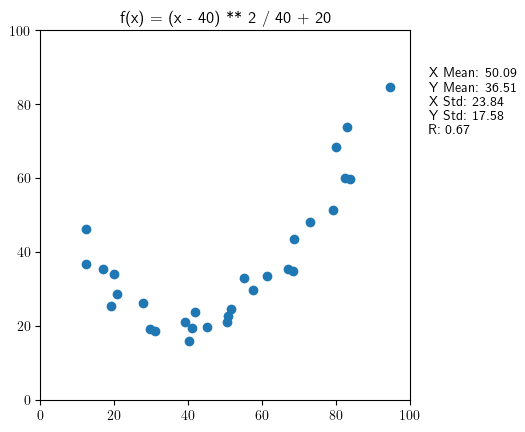

In [253]:
data = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 5, 30)
plt.title("f(x) = (x - 40) ** 2 / 40 + 20")
plot_summary(data)
plot_data(data)

In [471]:
def data_dist(source, target):
    return np.min(np.sum((target - source[:, np.newaxis]) ** 2, axis=0))
    # distances = np.sqrt(np.sum((source[:, :, np.newaxis] - target[:, np.newaxis, :]) ** 2, axis=0))
    # min_distances = np.min(distances, axis=1)
    # return np.sum(min_distances)
    # dists = cdist(data1, data2)
    # row_i, col_i = linear_sum_assignment(dists)
    # dist = np.sum(dists[row_i, col_i])
    # return dist

target = gen_dataset(lambda x: x, 0, 101, dom=[0, 100])
print(data_dist(np.array([16, 12]).reshape(2, 1), target))

8.0


In [362]:
data1 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 1, 30)
data2 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 1, 30)
dist = data_dist(data1, data2)
print("Distance between similar datasets:", dist)

data1 = gen_dataset(lambda x: x, 1, 30)
data2 = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 1, 30)
dist = data_dist(data1, data2)
print("Distance between different datasets:", dist)

data1 = gen_dataset(lambda x: x, 1, 30, dom=[10, 50])
data2 = gen_dataset(lambda x: x, 1, 30, dom=[50, 90])
dist = data_dist(data1, data2)
print("Distance between different domains:", dist)

Distance between similar datasets: 32.3370894087332
Distance between different datasets: 386.00245423601984
Distance between different domains: 834.4090326678563


Distance: 765.807062859576


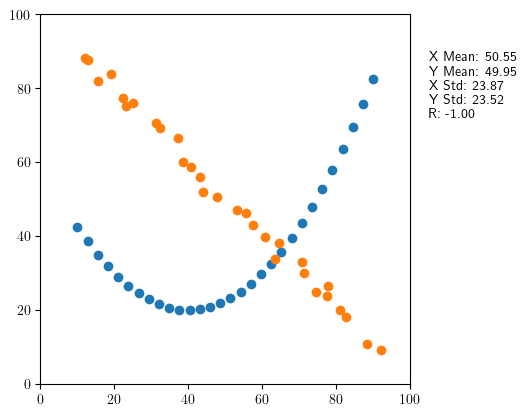

In [350]:
source = gen_dataset(lambda x: 100 - x, 3, 30)
target = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 0, 30)

print("Distance:", data_dist(source, target))
plot_data(target)
plot_data(source)
plot_summary(source)

In [466]:
def perturb(data, target, ds=0.1, temp=0.05):
    data = np.copy(data)
    while True:
        i = np.random.randint(np.shape(data)[1])
        old_dist = data_dist(data[:, i], target)
        new_point = data[:, i] + (np.random.randn(2) * ds)
        new_dist = data_dist(new_point, target)
        if new_dist < old_dist or temp > np.random.uniform():
            data[:, i] = new_point
            return data
        
# Sigmoid decay from `max` to `min` on the domain [0, 1]
def get_sigmoid_decay(max, min):
    return lambda x: min + (max - min) / (1 + np.exp(10 * x - 5))


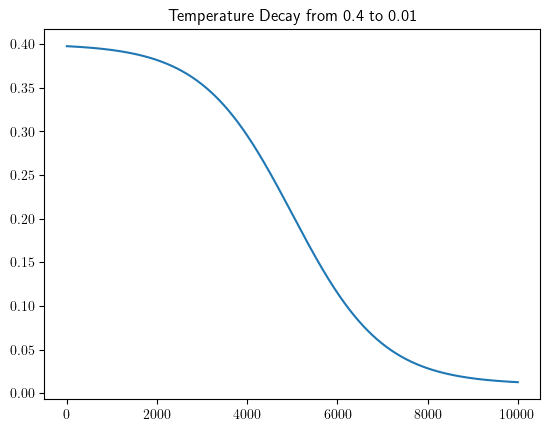

In [439]:
iters = 10000
decay = get_sigmoid_decay(0.4, 0.01)
X = np.arange(1, iters + 1)
Y = decay(X / iters)
plt.title("Temperature Decay from 0.4 to 0.01")
plt.plot(X, Y)
plt.show()

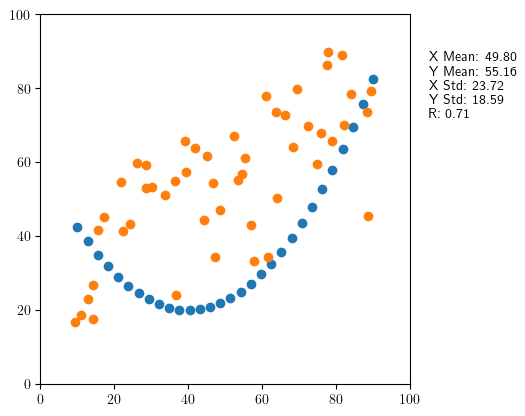

Iter 60000: (4.52 s), 33388/30000 updates
Iter 120000: (9.16 s), 29234/30000 updates
Iter 180000: (13.59 s), 19335/30000 updates
Iter 240000: (18.15 s), 7102/30000 updates
Iter 300000: (22.79 s), 2335/30000 updates


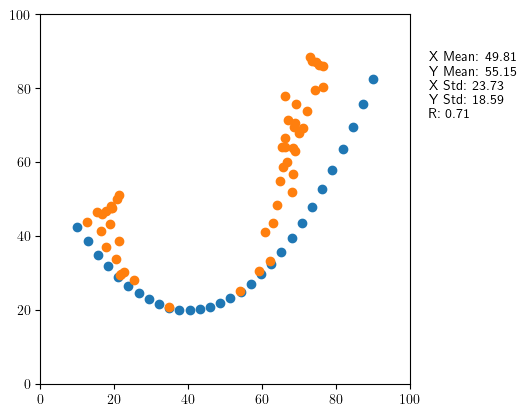

In [483]:
N = 50
X = np.linspace(10, 90, N)
Y = 25 + X / 2
source = np.vstack([
    X + np.random.uniform(-3, 3, N),
    Y + np.random.uniform(-25, 25, N)
])

target = gen_dataset(lambda x: (x - 40) ** 2 / 40 + 20, 0, 30, dom=[10, 90])

plot_data(target)
plot_data(source)
plot_summary(source)
plt.show()

start = time.time()
source_stats = summary_statistics(source)
count = 0
N = 300000
decay = get_sigmoid_decay(0.4, 0.01)
for i in range(N):
    perturbed_source = perturb(source, target, ds=0.1, temp=decay(i / N))
    perturbed_stats = summary_statistics(perturbed_source)
    if np.allclose(source_stats, perturbed_stats, atol=0.01):
        source = perturbed_source
        count += 1
    if (i + 1) % (N // 5) == 0:
        print(f"Iter {i + 1}: ({time.time() - start:.2f} s), {count}/{N // 10} updates")
        count = 0

plot_data(target)
plot_data(source)
plot_summary(source)
plt.show()